In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [51]:
tf.keras.backend.set_floatx("float64")

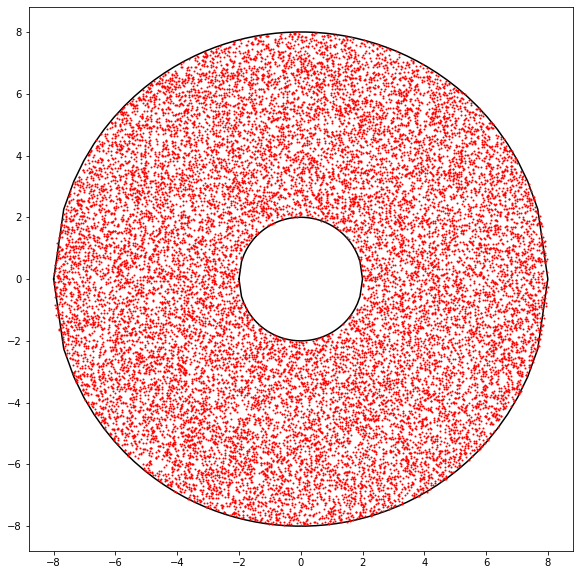

In [62]:
class CircularDomain:
    def __init__(self, r, R,
                 n_boundary_points, n_colloc_points,
                 bc1_val, bc2_val):
        if r >= R:
            r, R = R, r
        self.R, self.r = R, r
        self.n_bcp = n_boundary_points
        self.n_cp = int(n_colloc_points / np.pi / (R**2 - r**2) * 4*R**2)
        self.bc1_val, self.bc2_val = bc1_val, bc2_val
    
    def __circle(self, radius, n):
        m = n//2
        x = np.linspace(-radius, +radius, m, endpoint = True)
        y = np.sqrt(radius**2 - x**2)
        x = np.append(x, x[::-1])
        y = np.append(y, -y)
        return x, y
    
    def __isInsideCircle(self, x, y, radius):
        return x**2 + y**2 < radius**2
    
    def __isOutsideCircle(self, x, y, radius):
        return x**2 + y**2 > radius**2
    
    def __isDoughnot(self, x, y, r_out, r_in = 0):
        return r_in**2 < x**2 + y**2 < r_out**2
    
    def makeDomain(self):
        isInsideCircle_vec = np.vectorize(self.__isInsideCircle)
        isOutsideCircle_vec = np.vectorize(self.__isOutsideCircle)
        isDoughnot_vec = np.vectorize(self.__isDoughnot)
        plt.figure(figsize = (10, 10))
        for rad in [self.R, self.r]:
            x, y = self.__circle(rad, self.n_bcp)
            plt.plot(x, y, "k")
        points = (2 * (np.random.rand(self.n_cp, 2) - .5)) * self.R # random in [0., 1.)
        x, y = points[:, 0], points[:, 1]
        x, y = x[isDoughnot_vec(x, y, self.R, self.r)], y[isDoughnot_vec(x, y, self.R, self.r)]
        plt.plot(x, y, marker = ".", color = "r", markersize = 2, linestyle = "")
        plt.axis("square")
        plt.show()
        xbc, ybc = self.__circle(self.r, self.n_bcp)
        bc1 = np.zeros([self.n_bcp, 3])
        bc1[:, 0], bc1[:, 1], bc1[:, 2] = xbc, ybc, self.bc1_val
        #
        xbc, ybc = self.__circle(self.R, self.n_bcp)
        bc2 = np.zeros([self.n_bcp, 3]) * 10
        bc2[:, 0], bc2[:, 1], bc2[:, 2] = xbc, ybc, self.bc2_val
        #
        colloc = np.zeros([x.shape[0], 2])
        colloc[:, 0], colloc[:, 1] = x, y
        data = np.append(bc1, bc2, axis = 0)
        self.colloc, self.data = colloc, data

c = CircularDomain(2., 8., 100, 20000, 1., 0.)
c.makeDomain()

x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [c.data[:, 0], c.data[:, 1], c.data[:, 2]])

x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [c.colloc[:, 0], c.colloc[:, 1]])

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x, dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [63]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

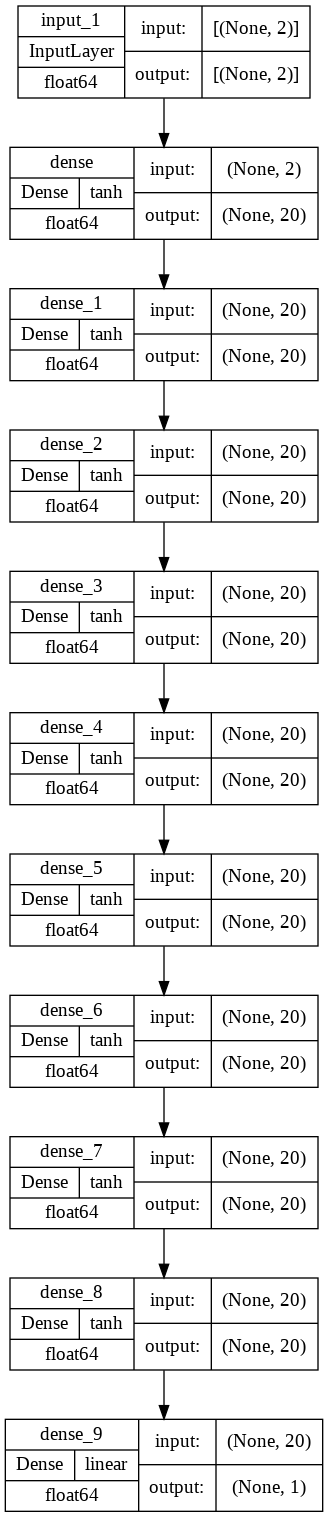

In [64]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 9, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

In [65]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [66]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = u_xx + u_yy
    return tf.reduce_mean(tf.square(F))

In [67]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 0.597
  200, 0.005
  400, 0.001
  600, 0.001
  800, 0.001
  999, 0.000

computation time: 163.555



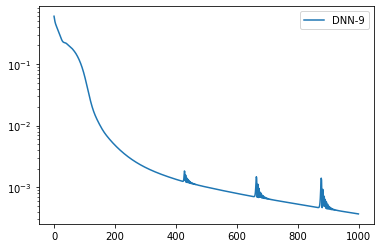

In [68]:
loss = 0
epochs = 1000
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = l+L
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.3f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

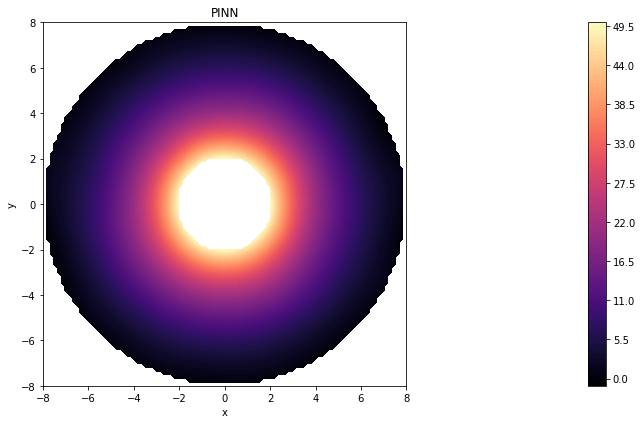

In [73]:
### plotting
plt.figure("", figsize=(12, 6))
#
n = 100
x, y = np.linspace(-c.R, +c.R, n), np.linspace(-c.R, +c.R, n)
X0, Y0 = np.meshgrid(x, y)
X = X0.reshape([n**2, 1])
Y = Y0.reshape([n**2, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy()
S[X**2 + Y**2 > c.R**2] = None
S[X**2 + Y**2 < c.r**2] = None
S = S.reshape(n, n)
#
plt.contourf(X0, Y0, 50. * S, cmap="magma", levels = 100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
plt.show()